<a href="https://colab.research.google.com/github/Tirthankar4/Encryptix/blob/main/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fraud-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F817870%2F1399887%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240719%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240719T103725Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D02515603955e5ad55421caaff332390ace476da2aa0112993811b655625b036095a352dd4c808d2db76673b5eca0fece7faa0b185644b98cc70d448aa7f802d9f8ef9a676eabeb5168fe6c52fa5b5dd41878f32450f39289f3252c956287f566a61b5c6f11d3d4df79ab46afdc6e42b2878e5a39811e06840a6bf741bcaa05dbb85bc18ce2a3a5ed7ae83a60b0355067e0ed3c74ba992e28520ab017b8715c814b87d697a5685e3e551bfec4a9eb8379b7bc614fd23e5b5f461df92619e53dfab632c6a32d372c920c248adbe06be8974c8508e940469071354f8ea0cfde92620ad73045a743420efef972f5222c1aeca60dd48d707390dcc7d5de762c1975b1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 211766662 bytes downloaded
Downloaded and uncompressed: fraud-detection
Data source import complete.


In [5]:
!pip install optuna

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import optuna
from sklearn.metrics import roc_auc_score, classification_report
import warnings

warnings.filterwarnings("ignore")

Import Dataset and get Basic Info

In [7]:
X = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv', index_col = 'Unnamed: 0')
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop               

Seperate target variable to prevent data leakage and keep aside a validation set to test model on unseen data

In [8]:
y = X.pop("is_fraud")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=69)

Remove unncessary symbols from text data for preprocessing

In [9]:
symb_remv = r'[_,/\-@#&:\s]'

obj_cols = ['merchant', 'category', 'first', 'last', 'street', 'city', 'state', 'job']

for col in obj_cols:
    X_train[col] = X_train[col].str.replace(symb_remv, '', regex=True).str.strip()
    X_valid[col] = X_valid[col].str.replace(symb_remv, '', regex=True).str.strip()

X_train["merchant"] = X_train["merchant"].str.replace("fraud", "", case = False)
X_valid["merchant"] = X_valid["merchant"].str.replace("fraud", "", case = False)

Label Encoding Gender

In [10]:
gender = LabelEncoder()

X_train["gender"] = gender.fit_transform(X_train["gender"])
X_valid["gender"] = gender.transform(X_valid["gender"])

Frequency encoding the following columns

In [11]:
freq_encd_cols = ["merchant", "first", "last", "category", "street", "city", "state", "job"]

for col in freq_encd_cols:

    freq_map = X_train[col].value_counts()

    X_train[col] = X_train[col].map(freq_map)
    X_valid[col] = X_valid[col].map(freq_map)

Checking mutual information scores to pick most useful features

<Axes: xlabel='MI_Score', ylabel='Feature'>

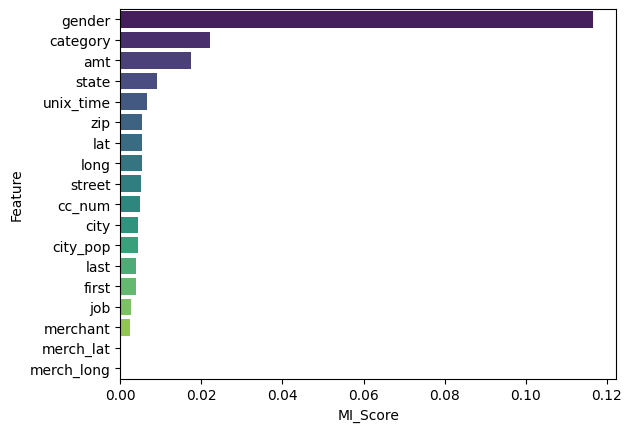

In [13]:
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

mi_scores = mutual_info_classif(X_train[num_cols], y_train, discrete_features=False)

mi_scores_df = pd.DataFrame({'Feature': num_cols, 'MI_Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='MI_Score', ascending=False)

sns.barplot(x='MI_Score', y='Feature', data = mi_scores_df, palette='viridis')

Checking correlation matrix to see any unseen relations by mutual_info_classif

<Axes: >

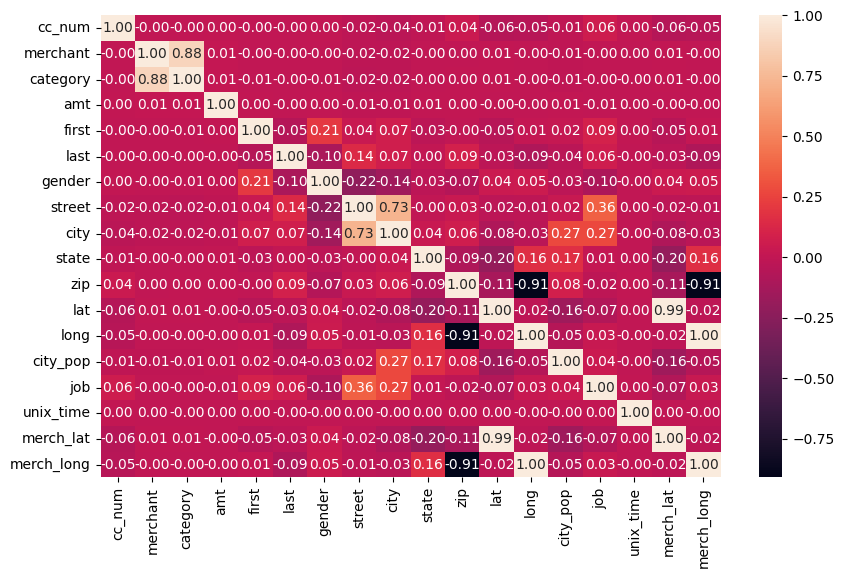

In [14]:
X_train[num_cols].corrwith(y_train)
plt.figure(figsize=(10, 6))
sns.heatmap(X_train[num_cols].corr(),annot = True, fmt = '.2f')

Picking the most important columns for training

In [15]:
X_train1 = pd.DataFrame(X_train[["gender", "category", "amt", "state", "unix_time", "zip", "lat", "long", "cc_num"]])
X_valid1 = pd.DataFrame(X_valid[["gender", "category", "amt", "state", "unix_time", "zip", "lat", "long", "cc_num"]])

Since dataset is imbalanced, using this ratio for better model quality

In [16]:
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

Baseline model to compare performance with

In [17]:
dt_model = DecisionTreeClassifier(random_state = 69)

dt_model.fit(X_train1, y_train)

preds = dt_model.predict(X_valid1)

report = classification_report(y_valid, preds, target_names = ["Not Fraud", "Fraud"])

print("Classification report is:")
print(report)

Classification report is:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    257818
       Fraud       0.66      0.67      0.66      1517

    accuracy                           1.00    259335
   macro avg       0.83      0.83      0.83    259335
weighted avg       1.00      1.00      1.00    259335



Optuna for best hyperparameter searching

In [18]:
def objective(trial):
    param = {
        'eval_metric': 'auc',
        'reg_lambda': trial.suggest_float('lambda', 1.0, 4.0),
        'max_depth': trial.suggest_int('max_depth', 8, 16),
        'eta': trial.suggest_float('eta', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'tree_method':'hist',
        'n_estimators': 1000,
        'early_stopping_rounds':100,
        'scale_pos_weight': ratio,
        'device': 'cuda',
        'random_state': 69
    }

    model = XGBClassifier(**param)
    model.fit(X_train1, y_train, eval_set = [(X_valid1, y_valid)], verbose = 100)
    preds = model.predict_proba(X_valid1)[:, 1]
    score = roc_auc_score(y_valid, preds)
    return score

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(objective, n_trials=10)

[I 2024-07-19 10:53:27,002] A new study created in memory with name: no-name-751124d5-baa9-4c8f-a5b6-fc74f5575acf


[0]	validation_0-auc:0.99144
[100]	validation_0-auc:0.99559
[200]	validation_0-auc:0.99774
[300]	validation_0-auc:0.99830
[400]	validation_0-auc:0.99860
[500]	validation_0-auc:0.99883
[600]	validation_0-auc:0.99896
[700]	validation_0-auc:0.99907
[800]	validation_0-auc:0.99910
[900]	validation_0-auc:0.99915
[999]	validation_0-auc:0.99917


[I 2024-07-19 10:53:58,704] Trial 0 finished with value: 0.9991711664802476 and parameters: {'lambda': 2.1045924930115945, 'max_depth': 16, 'eta': 0.04314282938204529, 'subsample': 0.6059024656876345, 'colsample_bylevel': 0.7384913023809571, 'colsample_bytree': 0.6480368592027612}. Best is trial 0 with value: 0.9991711664802476.


[0]	validation_0-auc:0.99205
[100]	validation_0-auc:0.99571
[200]	validation_0-auc:0.99716
[300]	validation_0-auc:0.99767
[400]	validation_0-auc:0.99787
[500]	validation_0-auc:0.99813
[600]	validation_0-auc:0.99819
[700]	validation_0-auc:0.99824
[800]	validation_0-auc:0.99831
[900]	validation_0-auc:0.99834
[999]	validation_0-auc:0.99840


[I 2024-07-19 10:54:27,961] Trial 1 finished with value: 0.9983981893826028 and parameters: {'lambda': 2.522589089466674, 'max_depth': 14, 'eta': 0.04900878663829576, 'subsample': 0.5468186932150316, 'colsample_bylevel': 0.8784141648320827, 'colsample_bytree': 0.8485022046982057}. Best is trial 0 with value: 0.9991711664802476.


[0]	validation_0-auc:0.99067
[100]	validation_0-auc:0.99069


[I 2024-07-19 10:54:33,940] Trial 2 finished with value: 0.9912315197150747 and parameters: {'lambda': 1.1920181988689276, 'max_depth': 16, 'eta': 0.012582513275756687, 'subsample': 0.5072436072051167, 'colsample_bylevel': 0.8301241005539883, 'colsample_bytree': 0.7439721029647564}. Best is trial 0 with value: 0.9991711664802476.


[0]	validation_0-auc:0.98481
[100]	validation_0-auc:0.99411
[200]	validation_0-auc:0.99568
[300]	validation_0-auc:0.99661
[400]	validation_0-auc:0.99726
[500]	validation_0-auc:0.99754
[600]	validation_0-auc:0.99787
[700]	validation_0-auc:0.99804
[800]	validation_0-auc:0.99824
[900]	validation_0-auc:0.99838
[999]	validation_0-auc:0.99851


[I 2024-07-19 10:54:50,294] Trial 3 finished with value: 0.9985119118921012 and parameters: {'lambda': 1.1014060863499586, 'max_depth': 9, 'eta': 0.03771059621322896, 'subsample': 0.9932799624045721, 'colsample_bylevel': 0.743256354676591, 'colsample_bytree': 0.6673949767285924}. Best is trial 0 with value: 0.9991711664802476.


[0]	validation_0-auc:0.95112
[100]	validation_0-auc:0.99483
[200]	validation_0-auc:0.99777
[300]	validation_0-auc:0.99854
[400]	validation_0-auc:0.99892
[500]	validation_0-auc:0.99910
[600]	validation_0-auc:0.99919
[700]	validation_0-auc:0.99926
[800]	validation_0-auc:0.99931
[900]	validation_0-auc:0.99935
[999]	validation_0-auc:0.99935


[I 2024-07-19 10:55:12,972] Trial 4 finished with value: 0.9993594025716137 and parameters: {'lambda': 3.9270021435692892, 'max_depth': 12, 'eta': 0.09143400089339698, 'subsample': 0.8967718248689959, 'colsample_bylevel': 0.9889581534192264, 'colsample_bytree': 0.5272777155779846}. Best is trial 4 with value: 0.9993594025716137.


[0]	validation_0-auc:0.98978
[100]	validation_0-auc:0.99574
[200]	validation_0-auc:0.99727
[300]	validation_0-auc:0.99785
[400]	validation_0-auc:0.99806
[500]	validation_0-auc:0.99828
[600]	validation_0-auc:0.99840
[700]	validation_0-auc:0.99849
[800]	validation_0-auc:0.99858
[900]	validation_0-auc:0.99862
[999]	validation_0-auc:0.99863


[I 2024-07-19 10:55:41,752] Trial 5 finished with value: 0.9986272349747132 and parameters: {'lambda': 3.9366353861625543, 'max_depth': 15, 'eta': 0.048373867832239556, 'subsample': 0.5645361360692276, 'colsample_bylevel': 0.7440455394631791, 'colsample_bytree': 0.8567142435530974}. Best is trial 4 with value: 0.9993594025716137.


[0]	validation_0-auc:0.99021
[100]	validation_0-auc:0.99578
[200]	validation_0-auc:0.99624
[236]	validation_0-auc:0.99615


[I 2024-07-19 10:55:47,660] Trial 6 finished with value: 0.9963097188850031 and parameters: {'lambda': 2.332707128936381, 'max_depth': 9, 'eta': 0.06187935236008185, 'subsample': 0.5575105269009009, 'colsample_bylevel': 0.9826005193937701, 'colsample_bytree': 0.9654368333796155}. Best is trial 4 with value: 0.9993594025716137.


[0]	validation_0-auc:0.99098
[100]	validation_0-auc:0.99608
[200]	validation_0-auc:0.99665
[300]	validation_0-auc:0.99738
[400]	validation_0-auc:0.99777
[500]	validation_0-auc:0.99792
[600]	validation_0-auc:0.99814
[700]	validation_0-auc:0.99826
[800]	validation_0-auc:0.99833
[900]	validation_0-auc:0.99840
[999]	validation_0-auc:0.99847


[I 2024-07-19 10:56:08,679] Trial 7 finished with value: 0.9984740350708479 and parameters: {'lambda': 1.2450710938606948, 'max_depth': 11, 'eta': 0.07224981980684102, 'subsample': 0.5799060156232707, 'colsample_bylevel': 0.9080102361957372, 'colsample_bytree': 0.9860211338010973}. Best is trial 4 with value: 0.9993594025716137.


[0]	validation_0-auc:0.99003
[100]	validation_0-auc:0.99666
[200]	validation_0-auc:0.99774
[300]	validation_0-auc:0.99809
[400]	validation_0-auc:0.99835
[500]	validation_0-auc:0.99849
[600]	validation_0-auc:0.99863
[700]	validation_0-auc:0.99869
[800]	validation_0-auc:0.99872
[900]	validation_0-auc:0.99875
[999]	validation_0-auc:0.99877


[I 2024-07-19 10:56:37,805] Trial 8 finished with value: 0.9987725956498785 and parameters: {'lambda': 3.7821460312398814, 'max_depth': 16, 'eta': 0.06831894857571139, 'subsample': 0.6259559814605067, 'colsample_bylevel': 0.7193842189434894, 'colsample_bytree': 0.8168221066088146}. Best is trial 4 with value: 0.9993594025716137.


[0]	validation_0-auc:0.97545
[100]	validation_0-auc:0.99664
[200]	validation_0-auc:0.99779
[300]	validation_0-auc:0.99811
[400]	validation_0-auc:0.99837
[500]	validation_0-auc:0.99848
[600]	validation_0-auc:0.99857
[695]	validation_0-auc:0.99856


[I 2024-07-19 10:56:56,561] Trial 9 finished with value: 0.9985724728741594 and parameters: {'lambda': 2.9426172294187705, 'max_depth': 14, 'eta': 0.09037829921582131, 'subsample': 0.5547209572355739, 'colsample_bylevel': 0.5460774028462264, 'colsample_bytree': 0.8621462290385475}. Best is trial 4 with value: 0.9993594025716137.


In [19]:
xgb_study.best_params

{'lambda': 3.9270021435692892,
 'max_depth': 12,
 'eta': 0.09143400089339698,
 'subsample': 0.8967718248689959,
 'colsample_bylevel': 0.9889581534192264,
 'colsample_bytree': 0.5272777155779846}

Training optimal XgBoost model and checking performance

In [20]:
xgb_model = XGBClassifier(reg_lambda = 3.9270021435692892, max_depth = 12, eta = 0.09143400089339698, subsample = 0.8967718248689959, colsample_bylevel = 0.9889581534192264,
                      colsample_bytree = 0.5272777155779846, eval_metric = 'auc', n_estimators = 1000, device = 'cuda', scale_pos_weight = ratio,
                      early_stopping_rounds = 100, random_state = 69)

xgb_model.fit(X_train1, y_train, eval_set = [(X_valid1, y_valid)], verbose = False)

preds = xgb_model.predict(X_valid1)

report = classification_report(y_valid, preds, target_names = ["Not Fraud", "Fraud"])

print("Classification report is:")
print(report)

Classification report is:
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    257818
       Fraud       0.85      0.90      0.87      1517

    accuracy                           1.00    259335
   macro avg       0.92      0.95      0.94    259335
weighted avg       1.00      1.00      1.00    259335

